In [ ]:
import pymupdf
import cv2
from pathlib import Path
import sys
from skimage.morphology import skeletonize
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage import io as io
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.measure import find_contours

base_dir = Path.cwd().parent.resolve()

src_path = base_dir / "src"
sys.path.append(str(src_path))
print(src_path)

from line_detection import turn_page_to_image, extract_geometric_lines, group_lines_kdtree

/home/lillemor/Documents/lgd-utils/asset-data-extraction/src


In [76]:
pdf_path = Path( base_dir /"data/input/single_pages/maps/45004_27.pdf" )
pdf_path = Path( base_dir /"data/input/single_pages/boreprofile/29192_229.pdf" )
pdf_path = Path( base_dir /"data/input/single_pages/text/1801_9.pdf" )


doc = pymupdf.open(pdf_path)
page = doc[0]

In [77]:
image = turn_page_to_image(page)
edges, lines = extract_geometric_lines(page)

print(len(lines) if lines is not None else 0)


line_image= np.zeros_like(image)
for lin in lines:
    cv2.line(line_image, (int(lin.start.x), int(lin.start.y)),
                         (int(lin.end.x), int(lin.end.y)),
                         (225, 225, 225), 1)

# Save the image with LSD lines
cv2.imwrite(Path(base_dir/"data/lines.png"), line_image)

6645


True

In [78]:
# Assume lines_obj is now available; apply grouping
grouped_lines = group_lines_kdtree(lines, angle_thresh=10, dist_thresh=20)

# Create an empty mask
group_mask = np.zeros_like(image)

# Draw all grouped lines into the mask
for group in grouped_lines:
    for line in group.lines:
        pt1 = tuple(map(int, line.start.tuple))
        pt2 = tuple(map(int, line.end.tuple))
        cv2.line(group_mask, pt1, pt2, (255,255,255), 1)


# Save the output mask
cv2.imwrite(Path(base_dir/"data/group_mask.png"), group_mask)

True

In [79]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Create a color image for grouped line visualization
grouped_color_mask = np.zeros((*gray.shape, 3), dtype=np.uint8)

import random
random.seed(42)

# Draw grouped lines and connect endpoints
for group in grouped_lines:
    color = tuple(random.randint(100, 255) for _ in range(3))  # Random BGR color

    for line in group.lines:
        pt1 = tuple(map(int, line.start.tuple))
        pt2 = tuple(map(int, line.end.tuple))
        cv2.line(grouped_color_mask, pt1, pt2, color, 1)

    endpoint_coords = [p.tuple for p in group.endpoints]
    for i in range(len(endpoint_coords)):
        for j in range(i + 1, len(endpoint_coords)):
            p1, p2 = endpoint_coords[i], endpoint_coords[j]
            if np.linalg.norm(np.subtract(p1, p2)) < 10:
                cv2.line(grouped_color_mask, tuple(map(int, p1)), tuple(map(int, p2)), color, 1)

# Save the final image
cv2.imwrite(Path(base_dir/"data/grouped_color_mask.png"), grouped_color_mask)

True

In [ ]:

gray_image = rgb2gray(image)
#Denoise the image
filtered_mask = np.zeros_like(gray_image)

denoised_image = gaussian(gray_image, sigma=2)
thresh = threshold_otsu(denoised_image)
binary_image = denoised_image < thresh

binary = np.zeros(shape=binary_image.shape)
binary[binary_image] = 1

contours = find_contours(binary, level=0.2)
for contour in contours:
    plt.plot(contour[:,1], contour[:,0], linewidth=0.5)
plt.imshow(filtered_mask, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image with Detected Contours')
labs, count = measure.label(binary, return_num=True)
print('{} shapes were found'.format(count))
plt.savefig(Path(base_dir) / "data" / "contours.png", bbox_inches='tight', dpi=300)
plt.close()

1977 shapes were found


In [81]:
from scipy.spatial import cKDTree
import numpy as np

def compute_tangent_angle(contour: np.ndarray, position: str = 'start', k: int = 5) -> float:
    if len(contour) < k + 1:
        return None  # Not enough points
    if position == 'start':
        vec = contour[k] - contour[0]
    else:  # 'end'
        vec = contour[-1] - contour[-(k+1)]
    return np.arctan2(vec[0], vec[1])  # (y, x)

def merge_contours_with_angle(contours: list[np.ndarray], dist_thresh=10, angle_thresh=np.pi/8) -> list[np.ndarray]:
    endpoints = []
    for i, contour in enumerate(contours):
        endpoints.append((contour[0], i, 'start', compute_tangent_angle(contour, 'start')))
        endpoints.append((contour[-1], i, 'end', compute_tangent_angle(contour, 'end')))

    points = np.array([pt[0] for pt in endpoints])
    tree = cKDTree(points)

    merged_contours = contours.copy()
    used = set()

    for i, (pt1, idx1, tag1, angle1) in enumerate(endpoints):
        if (idx1, tag1) in used or angle1 is None:
            continue
        for j in tree.query_ball_point(pt1, r=dist_thresh):
            if i == j:
                continue
            pt2, idx2, tag2, angle2 = endpoints[j]
            if (idx2, tag2) in used or idx1 == idx2 or angle2 is None:
                continue

            angle_diff = abs(angle1 - angle2)
            angle_diff = min(angle_diff, 2 * np.pi - angle_diff)
            if angle_diff > angle_thresh:
                continue  # angle too different

            c1 = merged_contours[idx1]
            c2 = merged_contours[idx2]
            if tag1 == 'end' and tag2 == 'start':
                merged = np.vstack([c1, c2])
            elif tag1 == 'start' and tag2 == 'end':
                merged = np.vstack([c2, c1])
            elif tag1 == 'end' and tag2 == 'end':
                merged = np.vstack([c1, c2[::-1]])
            elif tag1 == 'start' and tag2 == 'start':
                merged = np.vstack([c2[::-1], c1])
            merged_contours[idx1] = merged
            used.add((idx2, tag2))
            break

    return [c for i, c in enumerate(merged_contours) if not any((i, t) in used for t in ('start', 'end'))]


1977 shapes were found


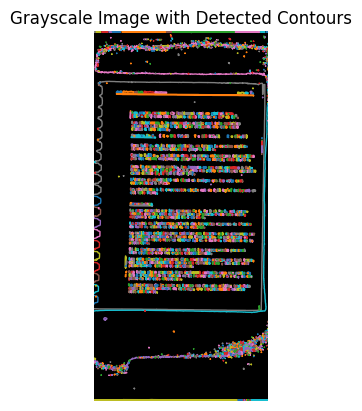

In [82]:
merged = merge_contours_with_angle(contours, dist_thresh=10, angle_thresh=np.pi/24)

for contour in merged:
    plt.plot(contour[:,1], contour[:,0], linewidth=1)
plt.imshow(filtered_mask, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image with Detected Contours')
labs, count = measure.label(binary, return_num=True)
print('{} shapes were found'.format(count))


In [ ]:
### morphological cleaning
# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Denoise
blurred = cv2.GaussianBlur(gray, (5, 5), sigmaX=1.2)

# Adaptive thresholding to enhance lines
thresh = cv2.adaptiveThreshold(
    blurred, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV,
    blockSize=15,
    C=10
)

# Morphological cleanup
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
cv2.imwrite(Path(base_dir/"data/cleaned.png"), cleaned)

In [ ]:
###Morphological extraction

closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

# Step 4: Skeletonize the result to 1-pixel width lines
skeleton = skeletonize(closed > 0).astype(np.uint8) * 255

# Step 5: Optional - filter out short contours
contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Create blank canvas to draw filtered contours
filtered_mask = np.zeros_like(skeleton)

for cnt in contours:
    length = cv2.arcLength(cnt, False)
    # if length > 50:  # adjust length threshold to filter out noise
    cv2.drawContours(filtered_mask, [cnt], -1, 255, thickness=1)

# Save the final filtered contour line map
cv2.imwrite(Path(base_dir/"data/contour_line_mask_grayscale.png"), filtered_mask)